# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# TODO: Install any packages that you might need
!pip install torch
!pip install torchvision  
!pip install tqdm
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 465.8 kB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 17.2 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip instal

In [28]:
# TODO: Import any packages that you might need
import torch
import torchvision
import sagemaker
import os
import json
import boto3
import math
import shutil
import matplotlib.pyplot as plt
import IPython

from sagemaker.estimator import EstimatorBase
from tqdm import tqdm
from sagemaker import get_execution_role
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import (Rule, ProfilerRule, DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig,
rule_configs)
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
from mpl_toolkits.axes_grid1 import host_subplot
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from PIL import Image

## Data Download and Initial Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [13]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:44<00:00, 11.79it/s]


100%|██████████| 2299/2299 [03:16<00:00, 11.69it/s]


100%|██████████| 2666/2666 [03:54<00:00, 11.39it/s]


100%|██████████| 2373/2373 [03:21<00:00, 11.76it/s]


100%|██████████| 1875/1875 [02:34<00:00, 12.10it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

The Amazon Bin Image Dataset holds 500,000 images and metadata from bins of a pod in an operating Amazon Center. The images were captured as the bins were being transported by robots.

The images are not divided into labelled folders. In order to use them a prior division of train images would be necessary using the metadata JSON files by Amazon in the dataset S3 folder. That step is not necessary for this project since Udacity has kindly provided a JSON file that labelled 10,441 images into 5 different folders ranging from 1 to 5 items in each picture (these will be my classes). Therefore, it was decided that the files to be used for training, validation and testing would be the ones listed in the forementioned JSON file.

This reduced dataset is also convenient since the AWS resources used for training in this project are limited.

### Data Preprocessing


Separate images into train, evaluation and test dataset:
- Train set: 70% of data
- Eval set: 15% of data
- Test set: 15% of data

Creating train, test and evaluation folders with respective classes subfolders:

In [12]:
# Create train, evaluation and test folders
for folder in ['train','evaluation','test']:
    # Create folders
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f'Folder {folder} created.')
        
        # Create classes subfolders
        for i in range(1,6):
            sub_path = os.path.join(folder, str(i))
            os.makedirs(sub_path)
            print(f'Subfolder for class {i}, in folder {folder} created.')

Folder train created.
Subfolder for class 1, in folder train created.
Subfolder for class 2, in folder train created.
Subfolder for class 3, in folder train created.
Subfolder for class 4, in folder train created.
Subfolder for class 5, in folder train created.
Folder evaluation created.
Subfolder for class 1, in folder evaluation created.
Subfolder for class 2, in folder evaluation created.
Subfolder for class 3, in folder evaluation created.
Subfolder for class 4, in folder evaluation created.
Subfolder for class 5, in folder evaluation created.
Folder test created.
Subfolder for class 1, in folder test created.
Subfolder for class 2, in folder test created.
Subfolder for class 3, in folder test created.
Subfolder for class 4, in folder test created.
Subfolder for class 5, in folder test created.


Separating the data into train, evaluation and test folders:

In [23]:
folder = 'train_data'
for cls in os.listdir(folder): # Iteration in each subfolder of 'train_data' (each class of image)
    # Getting the path of the subfolder
    sub_path = os.path.join(folder, cls)
    print(f'Working on class {cls}')
    
    # Defining the number of files in each train folder
    train_len = (math.floor(len(os.listdir(sub_path))*0.7))
    print(f'The train folder for class {cls} will have {train_len} images.')
    eval_len = (math.floor(len(os.listdir(sub_path))*0.15))
    print(f'The evaluation folder for class {cls} will have {eval_len} images.')
    
    # Getting the list of files for each phase:
    all_files = (sorted(os.listdir(sub_path)))
    list_train = all_files[:train_len]
    list_eval = all_files[train_len:(train_len + eval_len)]
    list_test = all_files[(train_len + eval_len):]
    # Creation of dictionary:
    phase_lists = {'train': list_train,
                  'evaluation': list_eval,
                  'test': list_test}
    
    # Copying files:
    for phase in ['train', 'evaluation', 'test']:
        for file in phase_lists[phase]:
            src = os.path.join(folder, cls, file)
            dst = os.path.join(phase, cls)
            shutil.copy(src, dst)

Working on class 2
The train folder for class 2 will have 1609 images.
The evaluation folder for class 2 will have 344 images.
Working on class 3
The train folder for class 3 will have 1866 images.
The evaluation folder for class 3 will have 399 images.
Working on class 5
The train folder for class 5 will have 1312 images.
The evaluation folder for class 5 will have 281 images.
Working on class 1
The train folder for class 1 will have 859 images.
The evaluation folder for class 1 will have 184 images.
Working on class 4
The train folder for class 4 will have 1661 images.
The evaluation folder for class 4 will have 355 images.


Moving train, evaluation and test folders into one local folder (StorageImages):

In [27]:
if 'StorageImages' not in os.listdir():
    os.makedirs('StorageImages')
    for phase in ['train', 'test', 'evaluation']:
        src = phase
        dst = 'StorageImages'
        shutil.move(src, dst)Qua

Uploading data to S3 bucket:

In [29]:
session = sagemaker.session.Session()
bucket = session.default_bucket()
role = get_execution_role()

inputs = session.upload_data(path='StorageImages', bucket=bucket, key_prefix='final_project')

## Model Training
This is the part where you can train a model. The type or architecture of the model you use is not important. 

### Benchmark Model

Before any type of finetuning or hyperparameter optimization, I'll start checking the performance of the bechmark model (ResNet50) as presented by torchvision without any kind of modification.

In [3]:
# Get role
role = get_execution_role()

# Create Estimator
benchmark_estimator = PyTorch(
    entry_point='benchmark_model.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.c5.4xlarge'
)

In [ ]:
# Fitting the estimator
input_data = 's3://' + sagemaker.session.Session().default_bucket() + '/final_project'

benchmark_estimator.fit(
    {'train': input_data + '/train',
    'evaluation': input_data + '/evaluation',
    'test': input_data + '/test'}
)

2022-03-19 23:10:35 Starting - Starting the training job...
2022-03-19 23:10:54 Starting - Preparing the instances for trainingProfilerReport-1647731435: InProgress
......
2022-03-19 23:11:58 Downloading - Downloading input data............
2022-03-19 23:13:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-19 23:13:50,476 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-19 23:13:50,478 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-19 23:13:50,485 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-19 23:13:50,489 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-19 23:13:50,806 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-19 23:13:

Getting training results

In [5]:
benchmark_estimator.logs()

2022-03-20 00:10:54 Starting - Preparing the instances for training
2022-03-20 00:10:54 Downloading - Downloading input data
2022-03-20 00:10:54 Training - Training image download completed. Training in progress.
2022-03-20 00:10:54 Uploading - Uploading generated training model
2022-03-20 00:10:54 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-19 23:13:50,476 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-19 23:13:50,478 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-19 23:13:50,485 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-19 23:13:50,489 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-19 23:13:50,806 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-19 

As seen in the last cell, the training accuracy for the benchmark model was of 30%. By employing model finetuning and hyperparameter optimization, I will try to increase this metric.

### Model Finetuning

By modifying the fully connected layers of the ResNet pretrained model, I will try to increase the model accuracy.

In [12]:
# Get role
role = get_execution_role()

# Create model finetuning Estimator
finetuning_estimator = PyTorch(
    entry_point='model_finetuning.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.2xlarge'
)

In [13]:
# Fitting the model finetuning estimator
input_data = 's3://' + sagemaker.session.Session().default_bucket() + '/final_project'

finetuning_estimator.fit(
    {'train': input_data + '/train',
    'evaluation': input_data + '/evaluation',
    'test': input_data + '/test'}
)

2022-03-20 01:08:21 Starting - Starting the training job...ProfilerReport-1647738501: InProgress
...
2022-03-20 01:09:11 Starting - Launching requested ML instances.........
2022-03-20 01:10:47 Starting - Preparing the instances for training......
2022-03-20 01:11:52 Downloading - Downloading input data............
2022-03-20 01:13:49 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-20 01:13:50,326 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-20 01:13:50,328 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-20 01:13:50,336 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-20 01:13:51,753 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-20 01:13:52,211 sagemaker-training-tool

As shown in the logs above, the attempt at finetuning did not improve the model's accuracy. After modifying the fully connected layers of the ResNet50 model, the best metric value was of 26.3%.

It was also observed that the model was not converging after the forth epoch. That means that even with more epochs the model would not present better results.

### Hyperparameter Optimization

In this section, I will try to improve the model accuracy by attempting hyperparameter optimization using the benchmarked model as foundation since it was the model with the best accuracy so far.

In [25]:
#TODO: Declare your model training hyperparameter.
hyperparameter_range = {
    'lr': ContinuousParameter(0.001, 0.1),
    'epochs': IntegerParameter(3,5),
    'train_batch_size': CategoricalParameter([16,32,64])
}

objective_metric = 'average evaluation loss'
objective_type = 'Minimize'
metric_definition = [{'Name': 'average evaluation loss', 'Regex': 'Test set average loss: ([0-9\\.]+)'}]

I chose to try to optimize the hyperparameters above

In [26]:
# Get role
role = get_execution_role()

# Create Estimator
estimator = PyTorch(
    entry_point='benchmark_model.py',
    role=role,
    py_version='py36',
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.2xlarge'
)

# Create Hyperparameter Tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric,
    hyperparameter_range,
    metric_definition,
    max_jobs=18,
    max_parallel_jobs=6,
    objective_type=objective_type
)

In [ ]:
# Fitting the tuner
input_data = 's3://' + sagemaker.session.Session().default_bucket() + '/final_project'

tuner.fit(
    {'train': input_data + '/train',
    'evaluation': input_data + '/evaluation',
    'test': input_data + '/test'}
)

...................................................................................................................................................................

Getting the best job:

In [3]:
tuning_job_name = 'pytorch-training-220320-0249'
attached_tuner = HyperparameterTuner.attach(tuning_job_name)
attached_tuner

In [4]:
attached_tuner.best_training_job()

'pytorch-training-220320-0249-015-1f546dd8'

In [5]:
best_estimator = attached_tuner.best_estimator()
best_estimator


2022-03-20 05:59:43 Starting - Preparing the instances for training
2022-03-20 05:59:43 Downloading - Downloading input data
2022-03-20 05:59:43 Training - Training image download completed. Training in progress.
2022-03-20 05:59:43 Uploading - Uploading generated training model
2022-03-20 05:59:43 Completed - Training job completed


In [6]:
all_hyp = best_estimator.hyperparameters()
all_hyp

{'_tuning_objective_metric': '"average evaluation loss"',
 'epochs': '4',
 'lr': '0.0012817345563836038',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-03-20-02-49-14-661"',
 'sagemaker_program': '"benchmark_model.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-20-02-49-14-661/source/sourcedir.tar.gz"',
 'train_batch_size': '"16"'}

Looking at the logs, we can actually see the values for test average loss and accuracy:

- Test set average loss: 1.3361
- Accuracy: 584/1571 (37%)

When compared to the benchmark model logs presented previously on the notebook, it is noticeable the improvement of the model's metrics. 
In absolute terms, this value of 0.37 for accuracy would be considered too low to be satisfactory. But since the main objective of this project is not to obtain the maximum possible accuracy or minimal test average loss, it was decided that this model would be the one used in later steps of the work.

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Model Profiling and Debugging and Multi-Instance Training

**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

**TODO:** Train the model using multi-instances.

In [16]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [17]:
# TODO: Create and fit an estimator

batch_size = int(all_hyp['train_batch_size'][1:3])
epochs = int(all_hyp['epochs'])
lr = float(all_hyp['lr'])

hyperparameters = {'train_batch_size':batch_size, 'epochs': epochs, 'lr': lr}

estimator = PyTorch(
    entry_point='hook_training_script.py',
    role=get_execution_role(),
    instance_count=2,
    instance_type='ml.m5.2xlarge',
    hyperparameters=hyperparameters,
    framework_version='1.8',
    py_version='py36',
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

In [ ]:
input_data = 's3://sagemaker-us-east-1-975527202598/final_project'

estimator.fit({
    'train': input_data + '/train',
    'test': input_data + '/test',
    'evaluation': input_data + '/evaluation'
})

2022-03-25 04:13:32 Starting - Starting the training job...
2022-03-25 04:14:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-03-25 04:15:02 Downloading - Downloading input data............
2022-03-25 04:17:06 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-25 04:17:08,797 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-25 04:17:08,799 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-25 04:17:08,807 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-25 04:17:08,814 sagemaker_pytorch_container.training IN

In [45]:
# TODO: Plot a debugging output.

# Getting session
session = sagemaker.session.Session()

# Getting training job name
job_name = estimator.latest_training_job.name

# Getting client and job description
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)

# Getting session region
region = session.boto_region_name

# Creating trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

# Getting names of tensors created during training
trial.tensor_names()

[2022-03-25 06:02:23.595 ip-172-16-143-85.ec2.internal:7397 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/debug-output
[2022-03-25 06:02:24.524 ip-172-16-143-85.ec2.internal:7397 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-03-25 06:02:25.546 ip-172-16-143-85.ec2.internal:7397 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.bn3.bias',
 'gradient/ResNet_layer1.0.bn3.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.0.conv3.weight',
 'gradient/ResNet_layer1.0.downsample.0.weight',
 'gradient/ResNet_layer1.0.downsample.1.bias',
 'gradient/ResNet_layer1.0.downsample.1.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.bn3.bias',
 'gradient/ResNet_layer1.1.bn3.weight',
 'gradient/ResNet_layer1.1.conv1.weight',
 'gradient/ResNet_layer1.1.conv2.weigh

We'll be working with the tensor 'CrossEntropyLoss_output_0'.

loaded TRAIN data
loaded EVALUATION data
completed TRAIN plot
completed EVALUATION plot


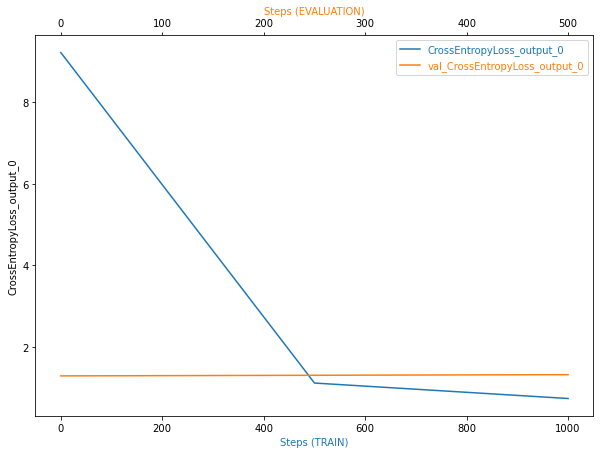

In [46]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVALUATION data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVALUATION)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVALUATION plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    
plot_tensor(trial, 'CrossEntropyLoss_output_0')

In [47]:
# TODO: Display the profiler output
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-975527202598/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/profiler-output


Profiler data from system is available


In [48]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=['CPU','GPU'],
    select_events=['total'],
)

[2022-03-25 06:05:01.231 ip-172-16-143-85.ec2.internal:7397 INFO metrics_reader_base.py:134] Getting 182 event files
[2022-03-25 06:05:01.412 ip-172-16-143-85.ec2.internal:7397 WARNING s3handler.py:183] Encountered the exception [SSL: DECRYPTION_FAILED_OR_BAD_RECORD_MAC] decryption failed or bad record mac (_ssl.c:2635) while reading s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/profiler-output/system/incremental/2022032504/1648182060.algo-1.json . Will retry now
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-2'}


In [49]:
rule_output_path = estimator.output_path + estimator.latest_training_job.name + '/rule-output'
print(rule_output_path)

s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/rule-output


In [50]:
!aws s3 ls {rule_output_path} --recursive 

2022-03-25 05:45:34     393817 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-03-25 05:45:34     243986 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-03-25 05:45:29        193 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-03-25 05:45:29        201 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-03-25 05:45:29       1903 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-03-25 05:45:29        127 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-03-25 05:45:29        200 pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-re

In [51]:
!aws s3 cp {rule_output_path} ./ --recursive 

download: s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-97552

In [52]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [53]:
IPython.display.HTML(filename=profiler_report_name + '/profiler-output/profiler-report.html')

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [55]:
# Retrieve trained model

jpeg_serializer = IdentitySerializer("image/jpeg")
json_deserializer = JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [56]:
role = get_execution_role()

model_location = 's3://sagemaker-us-east-1-975527202598/pytorch-training-2022-03-25-04-13-31-616/output/model.tar.gz'

pytorch_model = PyTorchModel(
    model_data=model_location,
    role = role,
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8',
    predictor_cls=ImagePredictor)

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance